In [1]:
import os
import pandas as pd
import numpy as np
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

FILENAME = 'results/results7.csv'
TESTDIR = 'tests/test7_unfix_c6'
PLOTDIR = 'tests/test7_unfix_c6/plots'
FORMAT = 'png'

# Create target Directory if don't exist
if not os.path.exists(PLOTDIR):
    os.mkdir(PLOTDIR)
    print("Directory " , PLOTDIR ,  " Created ")

In [2]:
''' Merge csv files '''

dlist = []
dirs = [d for d in os.listdir(TESTDIR) if os.path.isdir(os.path.join(TESTDIR,d))]
for d in dirs:
	d = os.path.abspath(TESTDIR+'/'+d)
	dlist += [os.path.join(d,file) for file in os.listdir(d) if file.endswith(".csv")]

df = pd.read_csv(dlist[0], skipinitialspace=True)
for x in range(1,len(dlist)):
    df = df.append(pd.read_csv(dlist[x], skipinitialspace=True))
df.to_csv(FILENAME,index=False)

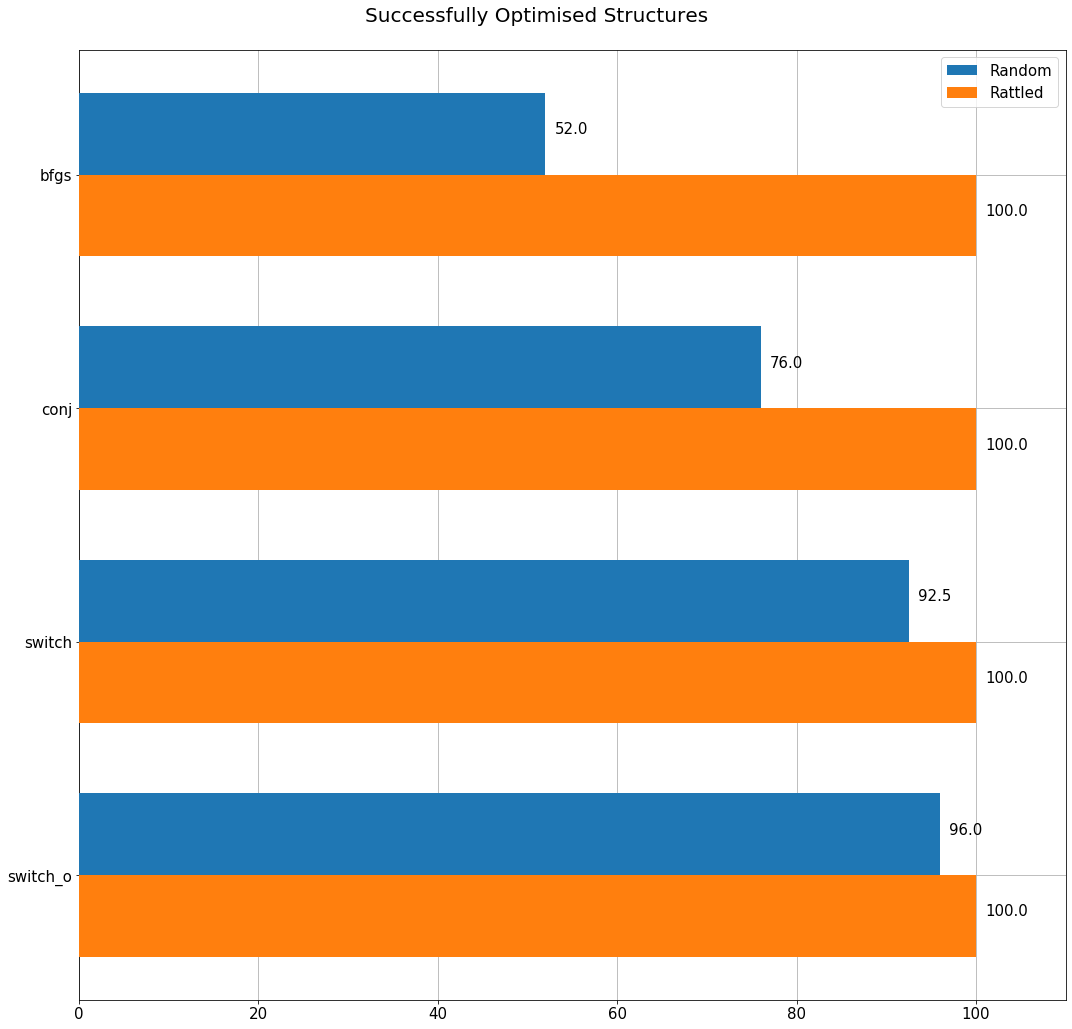

In [3]:
''' No. of optimised structures per method (diff no. of total structures) '''
''' Normalised to per cent '''

ran_succ_list = []
rat_succ_list = []
totals = {}


df = pd.read_csv(FILENAME, skipinitialspace=True)
labels = list(df['method'].unique())
dicts = {}

for method in labels:
	random = df[df['structure'].str.contains(
		"rat") == False]
	random = random.loc[random['method'] == method]
	rattled = df[df['structure'].str.contains(
		"rat")]
	rattled = rattled.loc[rattled['method'] == method]

	ran_succ = len([b for b in random['opt_succ'] if b])
	rat_succ = len([b for b in rattled['opt_succ'] if b])

	ran_perc = 0
	if len(random):
		ran_perc = ran_succ*100/len(random)
	rat_perc = 0
	if len(rattled):
		rat_perc = rat_succ*100/len(rattled)

	ran_succ_list.append(ran_perc)
	rat_succ_list.append(rat_perc)
    
''' Plot '''
    
y = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))
ax.grid(zorder=0)
rects1 = ax.barh(y - width/2, ran_succ_list, width, zorder=3, label='Random') # x% per init category
rects2 = ax.barh(y + width/2, rat_succ_list, width, zorder=3, label='Rattled')

# Add some text for labels, title and custom x-axis tick labels, etc.
for i, v in enumerate(ran_succ_list):
	ax.text(v + 1, i - width/2, str(v), fontsize=15)

for i, v in enumerate(rat_succ_list):
	ax.text(v + 1, i + width/2, str(v), fontsize=15)

ax.set_xlim(0,110)
ax.set_yticks(y)
ax.tick_params(labelsize=15)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.legend(fontsize=15)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Successfully Optimised Structures', fontsize=20)

plt.savefig(PLOTDIR+'/'+'OptSucc', format=FORMAT)
plt.show()

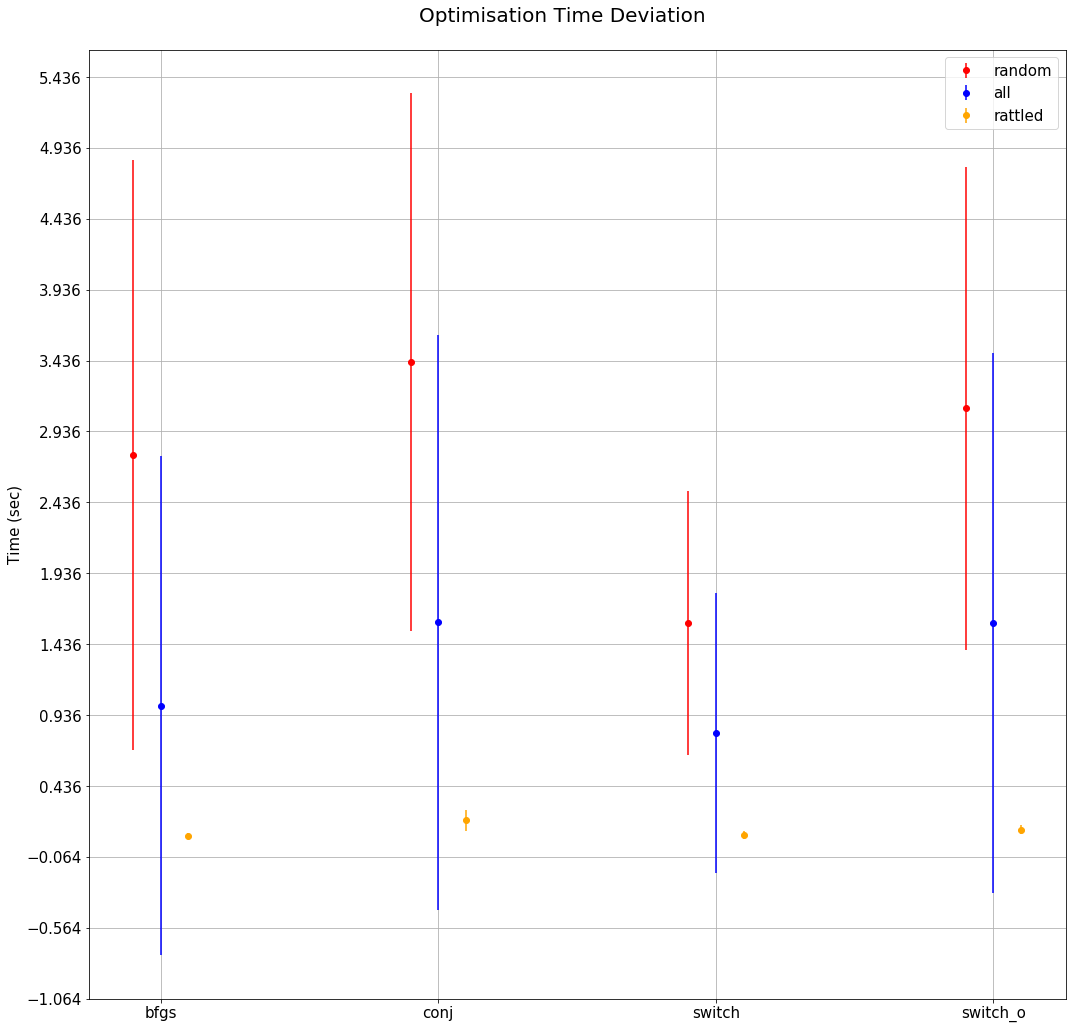

In [4]:
''' Variation of Optimisation time '''

df = pd.read_csv(FILENAME, skipinitialspace=True)

methods = list(df['method'].unique())
total_succ = df[df['opt_succ'] == True] # times of successful opt/ions
total_succ = total_succ[['method','opt_time']]

# successful optimisations per init
ran_succ = df[df['structure'].str.contains(
		"rat") == False]
ran_succ = ran_succ.loc[ran_succ['opt_succ'] == True][['method','opt_time']] 
rat_succ = df[df['structure'].str.contains(
		"rat") == True]
rat_succ = rat_succ.loc[rat_succ['opt_succ'] == True][['method','opt_time']]

# Total
means = total_succ.groupby(['method']).mean()
stdevs = total_succ.groupby(['method']).apply(np.std)

ms = means.join(stdevs, lsuffix='_m', rsuffix='_std')

# Random
ran_means = ran_succ.groupby(['method']).mean()
ran_stdevs = ran_succ.groupby(['method']).apply(np.std)

ran_ms = ran_means.join(ran_stdevs, lsuffix='_m', rsuffix='_std')
ms_all = ms.join(ran_ms, rsuffix='_ran')

# Rattled
rat_means = rat_succ.groupby(['method']).mean()
rat_stdevs = rat_succ.groupby(['method']).apply(np.std)

rat_ms = rat_means.join(rat_stdevs, lsuffix='_m', rsuffix='_std')
ms_all = ms_all.join(rat_ms, rsuffix='_rat')

fig, ax = plt.subplots(figsize=(15,15))

ind = np.arange(len(methods))  # the x locations for the groups
width = 0.3  # the width of the bars

ax.grid(zorder=0)
ax.errorbar(ind - width/3, ms_all['opt_time_m_ran'], ms_all['opt_time_std_ran'], 
            linestyle='None', marker='o', ecolor='red',mfc='red',
            zorder=3, mec='red', label='random')
ax.errorbar(ind, ms_all['opt_time_m'], ms_all['opt_time_std'], linestyle='None', 
            marker='o', ecolor='blue', mfc='blue',
            zorder=3, mec='blue', label='all')
ax.errorbar(ind + width/3, ms_all['opt_time_m_rat'], ms_all['opt_time_std_rat'], 
            linestyle='None', marker='o', ecolor='orange', mfc='orange',
            zorder=3, mec='orange', label='rattled')

ax.set_xticks(ind)
ax.set_xticklabels([row for row in ms_all.index])
ax.tick_params(labelsize=15)
ax.set_ylabel('Time (sec)', fontsize=15)
ax.legend(fontsize=15)
start, end = ax.get_ylim()
ax.set_yticks(np.arange(start, end, 0.5))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Optimisation Time Deviation', x=0.524, fontsize=20)

plt.savefig(PLOTDIR+'/'+'TimeDev', format=FORMAT)
plt.show()